<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:Black;
           color:White;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold">Twitter Sentiment Analysis With SVM, Naive Bayes,and Random Forest </h1>

</div>
<p><img src = "https://newsin.asia/wp-content/uploads/2016/07/plane.jpg" class="center"> </p>


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Importing Libraries </h1>
</div>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df =pd.read_csv(r'../input/twitter-airline-sentiment/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

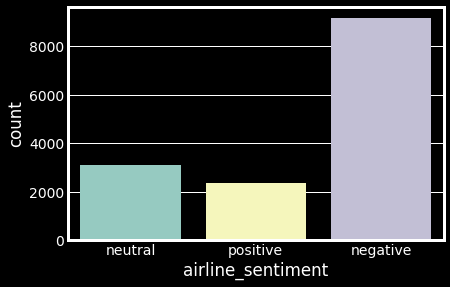

In [4]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

> Positive and neutral tweets are almost equal.

> Negative tweets are more than double of neutral or positive sentiments.

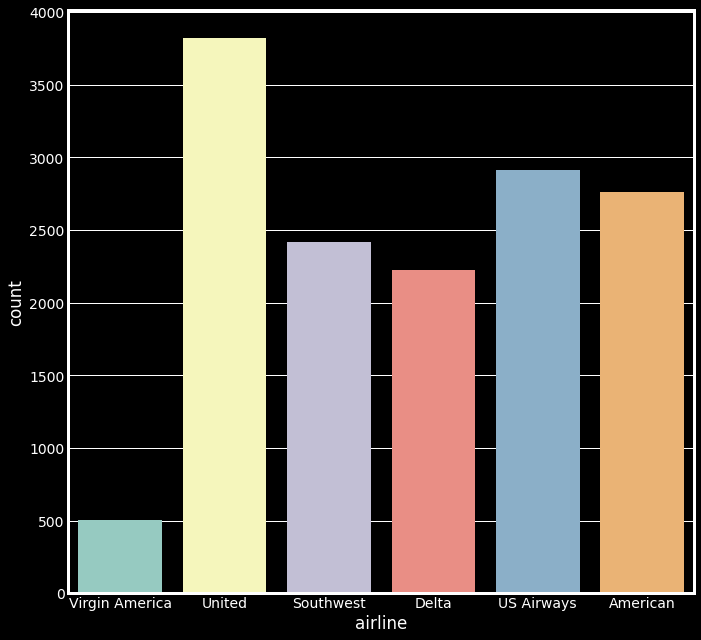

In [5]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

> United has the most number of flights.

> Virgin America has the least.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Utility Functions </h1>
</div>


In [6]:
# I am tokenizing the tweet and also taking tokens from second index onwards 
#as initital to gives airline name and '@' and lowering them and later making it back a sentence

def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

def check_scores(clf,X_train, X_test, y_train, y_test):
  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()

  fig, (ax1) = plt.subplots(1, 1)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  return train_accuracy, test_accuracy

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Text Preparation </h1>
</div>


In [7]:
# removing neutral tweets

df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [8]:
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [9]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
3,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


In [10]:
df['airline_sentiment'].unique()

array([1, 0])

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Creating tokens for tweets </h1>
</div>


In [11]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Base SVM model </h1>
</div>


In [12]:
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

Train confusion matrix is: 
[[6824   31]
 [ 151 1649]]

Test confusion matrix is: 
[[2291   32]
 [ 296  267]]

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886


Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863




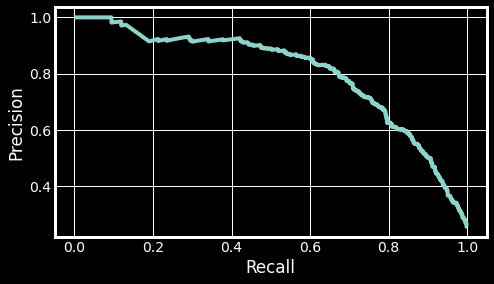

In [13]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy = check_scores(SVM,x_train, x_test, y_train, y_test)


> With increase in recall, precision decreases.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> After optimizing the hyperparameters for SVM </h1>
</div>


In [14]:
def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [15]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}



svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] C=0.1, gamma=scale, kernel=linear ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=0.1, gamma=scale, kernel=linear, total=   6.1s
[CV] C=0.1, gamma=scale, kernel=linear ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] ................ C=0.1, gamma=scale, kernel=linear, total=   5.7s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=  10.5s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   9.7s
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=scale, kernel=sigmoid, total=   6.1s
[CV] C=0.1, gamma=scale, kernel=sigmoid ..............................
[CV] ............... C=0.1, gamma=scale, kernel=sigmoid, total=   5.9s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] ................. C=0.1, gamma=auto, kernel=linear, total=   6.0s
[CV] C=0.1, gamma=auto, kernel=linear ................................
[CV] ................. C=0.1, gamma=auto, kernel=linear, total=   6.0s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.9min finished




Best parameters are: 
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2272   51]
 [ 245  318]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975




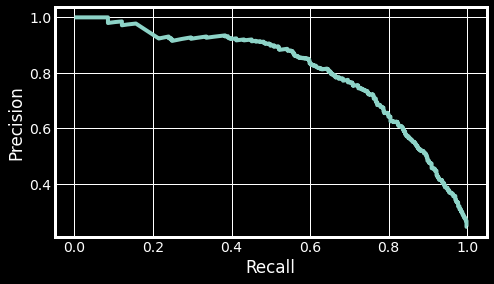

In [16]:
so_train_accuracy, so_test_accuracy= check_scores(svm_optimal,x_train, x_test, y_train, y_test)

> With increase in recall, preciison decreases which makes sense also.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold"> Using Gaussian Naive Bayes
 </h1>
</div>


Train confusion matrix is: 
[[5543 1312]
 [   0 1800]]

Test confusion matrix is: 
[[1623  700]
 [ 181  382]]

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2323
           1       0.35      0.68      0.46       563

    accuracy                           0.69      2886
   macro avg       0.63      0.69      0.63      2886
weighted avg       0.79      0.69      0.72      2886


Train accuracy score:  0.8484113229347198
Test accuracy score:  0.6947331947331947




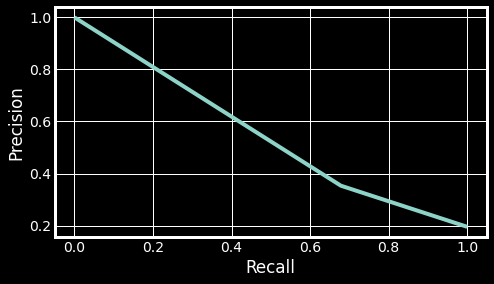

In [17]:
g_train_accuracy, g_test_accuracy =check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)


> It is interesting to see in Naive Bayes, we are getting linear relationship.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold">Using Random Forest
 </h1>
</div>



Train confusion matrix is: 
[[6829   26]
 [   5 1795]]

Test confusion matrix is: 
[[2215  108]
 [ 238  325]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886


Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801




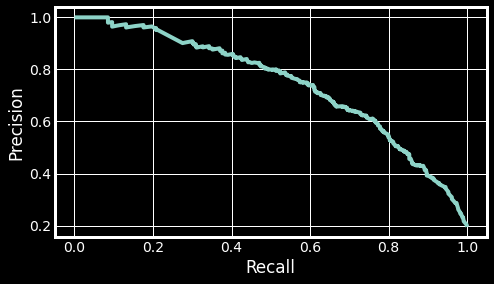

In [18]:
r_train_accuracy, r_test_accuracy= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold">Final Results
 </h1>
</div>



In [19]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy),
('SVM', s_train_accuracy, s_test_accuracy),
('SVM Optimized', so_train_accuracy, so_test_accuracy)]


Scores =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy'])
Scores.set_index('Model Name', inplace = True)
Scores

,Train Accuracy,Test Accuracy
Model Name,,
Random Forest,0.996418,0.880111
Gaussian Naive Bayes,0.848411,0.694733
SVM,0.978972,0.886348
SVM Optimized,0.996418,0.897436



<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:Arial
           ">
<h1 style="text-align:center;font-weight: bold">Conclusion
 </h1>
</div>

**Most of the models are doing pretty well here, and Optimized SVM performed the best.**